This is a simple example on how you can use a jupyter notebook to train your model :) 

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import utils
from dataloaders import load_cifar10, load_cifar10_augmented
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots

c:\Users\joerg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ImprovedModel(nn.Module):
    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            )
        )
        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        self.num_output_features = 4*4*128
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=3), # Flatten
            nn.Linear(self.num_output_features, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]

        features = self.feature_extractor(x)
        out = self.classifier(features)

        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [3]:
class BaseModel(nn.Module):
    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            )
        )
        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        self.num_output_features = 4*4*128
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=3), # Flatten
            nn.Linear(self.num_output_features, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]

        features = self.feature_extractor(x)
        out = self.classifier(features)

        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [4]:
def compare_plots(trainers: list, labels: list):
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    for trainer in trainers:
        utils.plot_loss(trainer.train_history["loss"], label=f"Training loss model {trainers.index(trainer) + 1}", npoints_to_average=10)
        utils.plot_loss(trainer.validation_history["loss"], label=f"Validation loss {trainers.index(trainer) + 1}")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    for trainer in trainers:
        utils.plot_loss(trainer.validation_history["accuracy"], label=f"Model {trainers.index(trainer) + 1}")
    plt.legend()
    plt.show()

In [5]:
# Model without batchnorm
epochs = 10
batch_size = 64
learning_rate = 5e-2
# learning_rate = 5e-4
early_stop_count = 4

# Augmented training dataset
dataloaders = load_cifar10(batch_size)

model = BaseModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders
)
trainer.train()
final_train_loss , final_train_accuracy = compute_loss_and_accuracy(dataloaders[0], trainer.model, trainer.loss_criterion)
final_val_loss , final_val_accuracy = compute_loss_and_accuracy(dataloaders[1], trainer.model, trainer.loss_criterion)
final_test_loss , final_test_accuracy = trainer.model_test()

print("Train Accuracy: " + str(final_train_accuracy))
print("Test Accuracy: " + str(final_test_accuracy))
print("Validation Accuracy: " + str(final_val_accuracy))

print("Train Loss: " + str(final_train_loss))
print("Test Loss: " + str(final_test_loss))
print("Validation Loss: " + str(final_val_loss))

Files already downloaded and verified
Files already downloaded and verified
BaseModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=3)
    (1): Linear(in_features=2048, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Epoch: 0, Batches per seconds: 26.02, Global step:    351, Validation Loss: 1.78, Validation Accu

In [6]:
# Model with batchnorm
epochs = 10
batch_size = 64
learning_rate = 5e-2
# learning_rate = 5e-4
early_stop_count = 4

# Augmented training dataset
dataloaders = load_cifar10_augmented(batch_size)

model2 = BaseModel(image_channels=3, num_classes=10)
trainer2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model2,
    dataloaders
)
trainer2.train()
final_train_loss , final_train_accuracy = compute_loss_and_accuracy(dataloaders[0], trainer2.model, trainer2.loss_criterion)
final_val_loss , final_val_accuracy = compute_loss_and_accuracy(dataloaders[1], trainer2.model, trainer2.loss_criterion)
final_test_loss , final_test_accuracy = trainer2.model_test()

print("Train Accuracy: " + str(final_train_accuracy))
print("Test Accuracy: " + str(final_test_accuracy))
print("Validation Accuracy: " + str(final_val_accuracy))

print("Train Loss: " + str(final_train_loss))
print("Test Loss: " + str(final_test_loss))
print("Validation Loss: " + str(final_val_loss))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
BaseModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=3)
    (1): Linear(in_features=2048, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Epoch: 0, Batches per seconds: 49.09, Global step:    742, 

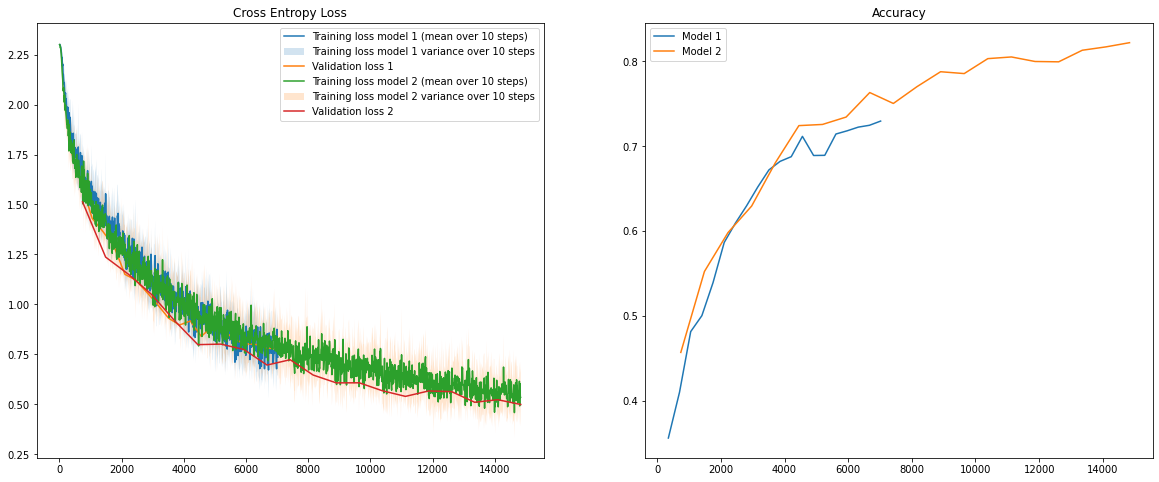

In [8]:
trainers = [trainer, trainer2]
labels = []

compare_plots(trainers, labels)